In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time
import s3fs
import xarray
t0=time.time()

In [14]:
# %load grid.py
################################################################################
#
# GEOS-5 grid generation script from Jiaweh 
# (see - https://github.com/JiaweiZhuang/cubedsphere )
#
# MIT License
#
# Copyright (c) 2017 Jiawei Zhuang
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#
###############################################################################
from itertools import product
import numpy as np

INV_SQRT_3 = 1.0 / np.sqrt(3.0)
ASIN_INV_SQRT_3 = np.arcsin(INV_SQRT_3)


def csgrid_GMAO(res):
    """
    Return cubedsphere coordinates with GMAO face orientation

    Parameters
    ----------
    res : cubed-sphere Resolution
    """

    CS = CSGrid(res, offset=-10)

    lon = CS.lon_center.transpose(2, 0, 1)
    lon_b = CS.lon_edge.transpose(2, 0, 1)
    lat = CS.lat_center.transpose(2, 0, 1)
    lat_b = CS.lat_edge.transpose(2, 0, 1)

    lon[lon < 0] += 360
    lon_b[lon_b < 0] += 360

    for a in [lon, lon_b, lat, lat_b]:

        for tile in [0, 1, 3, 4]:
            a[tile] = a[tile].T
        for tile in [3, 4]:
            a[tile] = np.flip(a[tile], 1)
        for tile in [3, 4, 2, 5]:
            a[tile] = np.flip(a[tile], 0)

        a[2], a[5] = a[5].copy(), a[2].copy()  # swap north&south pole

    return {'lon': lon, 'lat': lat, 'lon_b': lon_b, 'lat_b': lat_b}


class CSGrid(object):
    """Generator for cubed-sphere grid geometries.

    CSGrid computes the latitutde and longitudes of cell centers and edges
    on a cubed-sphere grid, providing a way to retrieve these geometries
    on-the-fly if your model output data does not include them.

    Attributes
    ----------
    {lon,lat}_center : np.ndarray
        lat/lon coordinates for each cell center along the cubed-sphere mesh
    {lon,lat}_edge : np.ndarray
        lat/lon coordinates for the midpoint of the edges separating each
        element on the cubed-sphere mesh.
    xyz_{center,edge} : np.ndarray
        As above, except coordinates are projected into a 3D cartesian space
        with common origin to the original lat/lon coordinate system, assuming
        a unit sphere.

    """

    def __init__(self, c, offset=None):
        """
        Parameters
        ----------
        c : int
            Number edges along each cubed-sphere edge.
            ======= ====================
               C    Lat/Lon Resolution
            ------- --------------------
               24    4 deg x 5 deg
             48,45   2 deg x 2.5 deg
             96,90   1 deg x 1.25 deg
            192,180  0.5 deg x 0.625 deg
            384,360  0.25 deg x 0.3125 deg
              720    0.12g deg x 0.15625 deg
        offset : float (optional)
            Degrees to offset the first faces' edge in the latitudinal
            direction. If not passed, then the western edge of the first face
            will align with the prime meridian.

        """
        self.c = c
        self.delta_y = 2. * ASIN_INV_SQRT_3 / c
        self.nx = self.ny = c + 1
        self.offset = offset

        self._initialize()

    def _initialize(self):

        c = self.c
        nx, ny = self.nx, self.ny

        lambda_rad = np.zeros((nx, ny))
        lambda_rad[ 0, :] = 3.*np.pi/4. # West edge
        lambda_rad[-1, :] = 5.*np.pi/4. # East edge

        theta_rad = np.zeros((nx, ny))
        theta_rad[ 0, :] = -ASIN_INV_SQRT_3 + (self.delta_y*np.arange(c+1)) # West edge
        theta_rad[-1, :] = theta_rad[0, :] # East edge

        # Cache the reflection points - our upper-left and lower-right corners
        lonMir1, lonMir2 = lambda_rad[0, 0], lambda_rad[-1, -1]
        latMir1, latMir2 = theta_rad[0, 0], theta_rad[-1, -1]

        xyzMir1 = latlon_to_cartesian(lonMir1, latMir1)
        xyzMir2 = latlon_to_cartesian(lonMir2, latMir2)

        xyzCross = np.cross(xyzMir1, xyzMir2)
        norm = np.sqrt(np.sum(xyzCross**2))
        xyzCross /= norm

        for i in range(1, c):

            lonRef, latRef = lambda_rad[0, i], theta_rad[0, i]
            xyzRef = np.asarray(latlon_to_cartesian(lonRef, latRef, ))

            xyzDot = np.sum(xyzCross*xyzRef)
            xyzImg = xyzRef - (2. * xyzDot * xyzCross)

            xsImg, ysImg, zsImg = xyzImg
            lonImg, latImg = cartesian_to_latlon(xsImg, ysImg, zsImg)

            lambda_rad[i, 0] = lonImg
            lambda_rad[i, -1] = lonImg
            theta_rad[i, 0] = latImg
            theta_rad[i, -1] = -latImg

        pp = np.zeros([3, c+1, c+1])

        # Set the four corners
        # print("CORNERS")
        for i, j in product([0, -1], [0, -1]):
            # print(i, j)
            pp[:, i, j] = latlon_to_cartesian(lambda_rad[i, j], theta_rad[i, j])

        # Map the edges on the sphere back to the cube. Note that all intersections are at x = -rsq3
        # print("EDGES")
        for ij in range(1, c+1):
            # print(ij)
            pp[:, 0, ij] = latlon_to_cartesian(lambda_rad[0, ij], theta_rad[0, ij])
            pp[1, 0, ij] = -pp[1, 0, ij] * INV_SQRT_3 / pp[0, 0, ij]
            pp[2, 0, ij] = -pp[2, 0, ij] * INV_SQRT_3 / pp[0, 0, ij]

            pp[:, ij, 0] = latlon_to_cartesian(lambda_rad[ij, 0], theta_rad[ij, 0])
            pp[1, ij, 0] = -pp[1, ij, 0] * INV_SQRT_3 / pp[0, ij, 0]
            pp[2, ij, 0] = -pp[2, ij, 0] * INV_SQRT_3 / pp[0, ij, 0]

        # # Map interiors
        pp[0, :, :] = -INV_SQRT_3
        # print("INTERIOR")
        for i in range(1, c+1):
            for j in range(1, c+1):
                # Copy y-z face of the cube along j=1
                pp[1, i, j] = pp[1, i, 0]
                # Copy along i=1
                pp[2, i, j] = pp[2, 0, j]

        _pp = pp.copy()
        llr, ttr = vec_cartesian_to_latlon(_pp[0], _pp[1], _pp[2])

        lambda_rad, theta_rad = llr.copy(), ttr.copy()

        # Make grid symmetrical to i = im/2 + 1
        for j in range(1, c+1):
            for i in range(1, c+1):
                # print("({}, {}) -> ({}, {})".format(i, 0, i, j))
                lambda_rad[i, j] = lambda_rad[i, 0]

        for j in range(c+1):
            for i in range(c//2):
                isymm = c - i
                # print(isymm)
                avgPt = 0.5*(lambda_rad[i, j] - lambda_rad[isymm, j])
                # print(lambda_rad[i, j], lambda_rad[isymm, j], avgPt)
                lambda_rad[i, j] = avgPt + np.pi
                lambda_rad[isymm, j] = np.pi - avgPt

                avgPt = 0.5*(theta_rad[i, j] + theta_rad[isymm, j])
                theta_rad[i, j] = avgPt
                theta_rad[isymm, j] = avgPt

        # Make grid symmetrical to j = im/2 + 1
        for j in range(c//2):
            jsymm = c - j
            for i in range(1, c+1):
                avgPt = 0.5*(lambda_rad[i, j] + lambda_rad[i, jsymm])
                lambda_rad[i, j] = avgPt
                lambda_rad[i, jsymm] = avgPt

                avgPt = 0.5*(theta_rad[i, j] - theta_rad[i, jsymm])
                theta_rad[i, j] = avgPt
                theta_rad[i, jsymm] = -avgPt

        # Final correction
        lambda_rad -= np.pi

        llr, ttr = lambda_rad.copy(), theta_rad.copy()

        #######################################################################
        ## MIRROR GRIDS
        #######################################################################

        new_xgrid = np.zeros((c+1, c+1, 6))
        new_ygrid = np.zeros((c+1, c+1, 6))

        xgrid = llr.copy()
        ygrid = ttr.copy()

        new_xgrid[..., 0] = xgrid.copy()
        new_ygrid[..., 0] = ygrid.copy()

        # radius = 6370.0e3
        radius = 1.

        for face in range(1, 6):
            for j in range(c+1):
                for i in range(c+1):
                    x = xgrid[i, j]
                    y = ygrid[i, j]
                    z = radius

                    if face == 1:
                        # Rotate about z only
                        new_xyz = rotate_sphere_3D(x, y, z, -np.pi/2., 'z')

                    elif face == 2:
                        # Rotate about z, then x
                        temp_xyz = rotate_sphere_3D(x, y, z, -np.pi/2., 'z')
                        x, y, z = temp_xyz[:]
                        new_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'x')

                    elif face == 3:
                        temp_xyz = rotate_sphere_3D(x, y, z, np.pi, 'z')
                        x, y, z = temp_xyz[:]
                        new_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'x')

                        if ((c % 2) != 0) and (j == c//2 - 1):
                            print(i, j, face)
                            new_xyz[0] = np.pi

                    elif face == 4:
                        temp_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'z')
                        x, y, z = temp_xyz[:]
                        new_xyz = rotate_sphere_3D(x, y, z,  np.pi/2., 'y')

                    elif face == 5:
                        temp_xyz = rotate_sphere_3D(x, y, z,  np.pi/2., 'y')
                        x, y, z = temp_xyz[:]
                        new_xyz = rotate_sphere_3D(x, y, z, 0., 'z')

                    # print((x, y, z), "\n", new_xyz, "\n" + "--"*40)

                    new_x, new_y, _ = new_xyz
                    new_xgrid[i, j, face] = new_x
                    new_ygrid[i, j, face] = new_y

        lon_edge, lat_edge = new_xgrid.copy(), new_ygrid.copy()

        #######################################################################
        ## CLEANUP GRID
        #######################################################################

        for i, j, f in product(range(c+1), range(c+1), range(6)):
            new_lon = lon_edge[i, j, f]
            if new_lon < 0:
                new_lon+= 2*np.pi
            if np.abs(new_lon) < 1e-10:
                new_lon = 0.
            lon_edge[i, j, f] = new_lon

            if np.abs(lat_edge[i, j, f]) < 1e-10:
                lat_edge[i, j, f] = 0.

        lon_edge_deg = np.rad2deg(lon_edge)
        lat_edge_deg = np.rad2deg(lat_edge)

        #######################################################################
        ## COMPUTE CELL CENTROIDS
        #######################################################################

        lon_ctr = np.zeros((c, c, 6))
        lat_ctr = np.zeros((c, c, 6))
        xyz_ctr = np.zeros((3, c, c, 6))
        xyz_edge = np.zeros((3, c+1, c+1, 6))

        for f in range(6):
            for i in range(c):
                last_x = (i == (c-1))
                for j in range(c):
                    last_y = (j == (c-1))

                    # Get the four corners
                    lat_corner = [lat_edge[  i,   j, f], lat_edge[i+1,   j, f],
                                  lat_edge[i+1, j+1, f], lat_edge[  i, j+1, f]]
                    lon_corner = [lon_edge[  i,   j, f], lon_edge[i+1,   j, f],
                                  lon_edge[i+1, j+1, f], lon_edge[  i, j+1, f]]

                    # Convert from lat-lon back to cartesian
                    xyz_corner = np.asarray(vec_latlon_to_cartesian(lon_corner, lat_corner))

                    # Store the edge information
                    xyz_edge[:, i, j, f] = xyz_corner[:, 0]
                    if last_x:
                        xyz_edge[:, i+1, j, f] = xyz_corner[:, 1]
                    if last_x or last_y:
                        xyz_edge[:, i+1, j+1, f] = xyz_corner[:, 2]
                    if last_y:
                        xyz_edge[:, i, j+1, f] = xyz_corner[:, 3]

                    e_mid = np.sum(xyz_corner, axis=1)
                    e_abs = np.sqrt(np.sum(e_mid * e_mid))
                    if e_abs > 0:
                        e_mid = e_mid / e_abs

                    xyz_ctr[:, i, j, f] = e_mid
                    _lon, _lat = cartesian_to_latlon(*e_mid)
                    lon_ctr[i, j, f] = _lon
                    lat_ctr[i, j, f] = _lat

        lon_ctr_deg = np.rad2deg(lon_ctr)
        lat_ctr_deg = np.rad2deg(lat_ctr)

        if self.offset is not None:
            lon_edge_deg += self.offset
            lon_ctr_deg += self.offset

        #######################################################################
        ## CACHE
        #######################################################################

        self.lon_center = lon_ctr_deg
        self.lat_center = lat_ctr_deg

        self.lon_edge = lon_edge_deg
        self.lat_edge = lat_edge_deg

        self.xyz_center = xyz_ctr
        self.xyz_edge = xyz_edge

def latlon_to_cartesian(lon, lat):
    """ Convert latitude/longitude coordinates along the unit sphere to cartesian
    coordinates defined by a vector pointing from the sphere's center to its
    surface.

    """

    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)

    return x, y, z
vec_latlon_to_cartesian = np.vectorize(latlon_to_cartesian)


def cartesian_to_latlon(x, y, z, ret_xyz=False):
    """ Convert a cartesian coordinate to latitude/longitude coordinates.

    Optionally return the original cartesian coordinate as a tuple.

    """

    xyz = np.array([x, y, z])
    vector_length = np.sqrt(np.sum(xyz*xyz, axis=0))
    xyz /= vector_length
    x, y, z = xyz

    if (np.abs(x) + np.abs(y)) < 1e-20:
        lon = 0.
    else:
        lon = np.arctan2(y, x)
    if lon < 0.:
        lon += 2*np.pi

    lat = np.arcsin(z)
    # If not normalizing vector, take lat = np.arcsin(z/vector_length)

    if ret_xyz:
        return lon, lat, xyz
    else:
        return lon, lat
vec_cartesian_to_latlon = np.vectorize(cartesian_to_latlon)


def spherical_to_cartesian(theta, phi, r=1):
    """ Convert spherical coordinates in the form (theta, phi[, r]) to
    cartesian, with the origin at the center of the original spherical
    coordinate system.

    """
    x = r * np.cos(phi) * np.cos(theta)
    y = r * np.cos(phi) * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z
vec_spherical_to_cartesian = np.vectorize(spherical_to_cartesian)


def cartesian_to_spherical(x, y, z):
    """ Convert cartesian coordinates to spherical in the form
    (theta, phi[, r]) with the origin remaining at the center of the
    original spherical coordinate system.

    """
    r = np.sqrt(x**2 + y**2 + z**2)
    #theta = np.arccos(z / r)
    theta = np.arctan2(y, x)
    phi = np.arctan2(z, np.sqrt(x**2 + y**2))

    # if np.abs(x) < 1e-16:
    #     phi = np.pi
    # else:
    #     phi = np.arctan(y / x)
    return theta, phi, r
vec_cartesian_to_spherical = np.vectorize(cartesian_to_spherical)


def rotate_sphere_3D(theta, phi, r, rot_ang, rot_axis='x'):
    """ Rotate a spherical coordinate in the form (theta, phi[, r])
    about the indicating axis, 'rot_axis'.

    This method accomplishes the rotation by projecting to a
    cartesian coordinate system and performing a solid body rotation
    around the requested axis.

    """
    cos_ang = np.cos(rot_ang)
    sin_ang = np.sin(rot_ang)

    x, y, z = spherical_to_cartesian(theta, phi, r)
    if rot_axis == 'x':
        x_new = x
        y_new = cos_ang*y + sin_ang*z
        z_new = -sin_ang*y + cos_ang*z
    elif rot_axis == 'y':
        x_new = cos_ang*x - sin_ang*z
        y_new = y
        z_new = sin_ang*x + cos_ang*z
    elif rot_axis == 'z':
        x_new = cos_ang*x + sin_ang*y
        y_new = -sin_ang*x + cos_ang*y
        z_new = z

    theta_new, phi_new, r_new = cartesian_to_spherical(x_new, y_new, z_new)

    return theta_new, phi_new, r_new

In [15]:
tc=time.time()
fs=s3fs.S3FileSystem(anon=True,client_kwargs={'endpoint_url': "https://mghp.osn.xsede.org"})
f1=fs.open('cnh-bucket-1/DYAMOND/c1440_llc2160/holding/tavg_01hr_3d_U_Mv/DYAMOND_c1440_llc2160.tavg_01hr_3d_U_Mv.20200123_2030z.nc4', 'rb')
f2=fs.open('cnh-bucket-1/DYAMOND/c1440_llc2160/holding/const_2d_asm_Mx/DYAMOND_c1440_llc2160.const_2d_asm_Mx.20200122_0000z.nc4','rb')
f3=fs.open('cnh-bucket-1/DYAMOND/c1440_llc2160/holding/geosgcm_guest/DYAMOND_c1440_llc2160.geosgcm_guest.20200206_2200z.nc4','rb')
f4=fs.open('cnh-bucket-1/DYAMOND/c1440_llc2160/holding/geosgcm_saltwater/DYAMOND_c1440_llc2160.geosgcm_saltwater.20200206_2200z.nc4','rb')
f5=fs.open('cnh-bucket-1/DYAMOND/c1440_llc2160/holding/inst_01hr_3d_T_Mv/DYAMOND_c1440_llc2160.inst_01hr_3d_T_Mv.20200119_2200z.nc4','rb')
ds  = xarray.open_dataset(f1, engine='h5netcdf')
dd  = xarray.open_dataset(f2, engine='h5netcdf')
dg  = xarray.open_dataset(f3, engine='h5netcdf')
dsw = xarray.open_dataset(f4, engine='h5netcdf')
dt  = xarray.open_dataset(f5, engine='h5netcdf')
elap=time.time()-tc
print(elap)

5.38713002204895


In [16]:
def plot_geos5_cs1440_layer(phi,scale=4,ncs=1440):
    """
      Plot a GEOS-5 cs1440 layer
    """
    import matplotlib.pyplot as plt
    import numpy as np
    ncols=4;
    nrows=3;
    s1=scale;s2=s1*ncols/nrows;fig = plt.figure(figsize=(s2*7.825,s1*8)) # Notice the equal aspect ratio
    ax = [fig.add_subplot(nrows,ncols,i+1) for i in range(nrows*ncols)]
    fn=[-1, 2,-1,-1, 4, 0, 1, 3,-1, 5,-1,-1];
    kr=[ 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0];
    i=0
    cmin=np.min(phi)
    cmax=np.max(phi)
    for a in ax:
        f=fn[i]
        if f >= 0:
            pp=phi[0,f*ncs+0:f*ncs+ncs,:]
            pp=np.rot90(pp,kr[i])
        i+=1
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect('auto')
        a.axis('equal')
        if f >= 0:
            a.imshow(pp,origin="lower",vmin=cmin,vmax=cmax)
    fig.subplots_adjust(wspace=0, hspace=0)


# In[19]:


In [17]:
phi=dd["FRLAND"][:,:,:]+dd["FRLANDICE"][:,:,:] # Get a "land" mask
phiU=ds["U"][:,51,:,:]                           # Get U at bottom layer


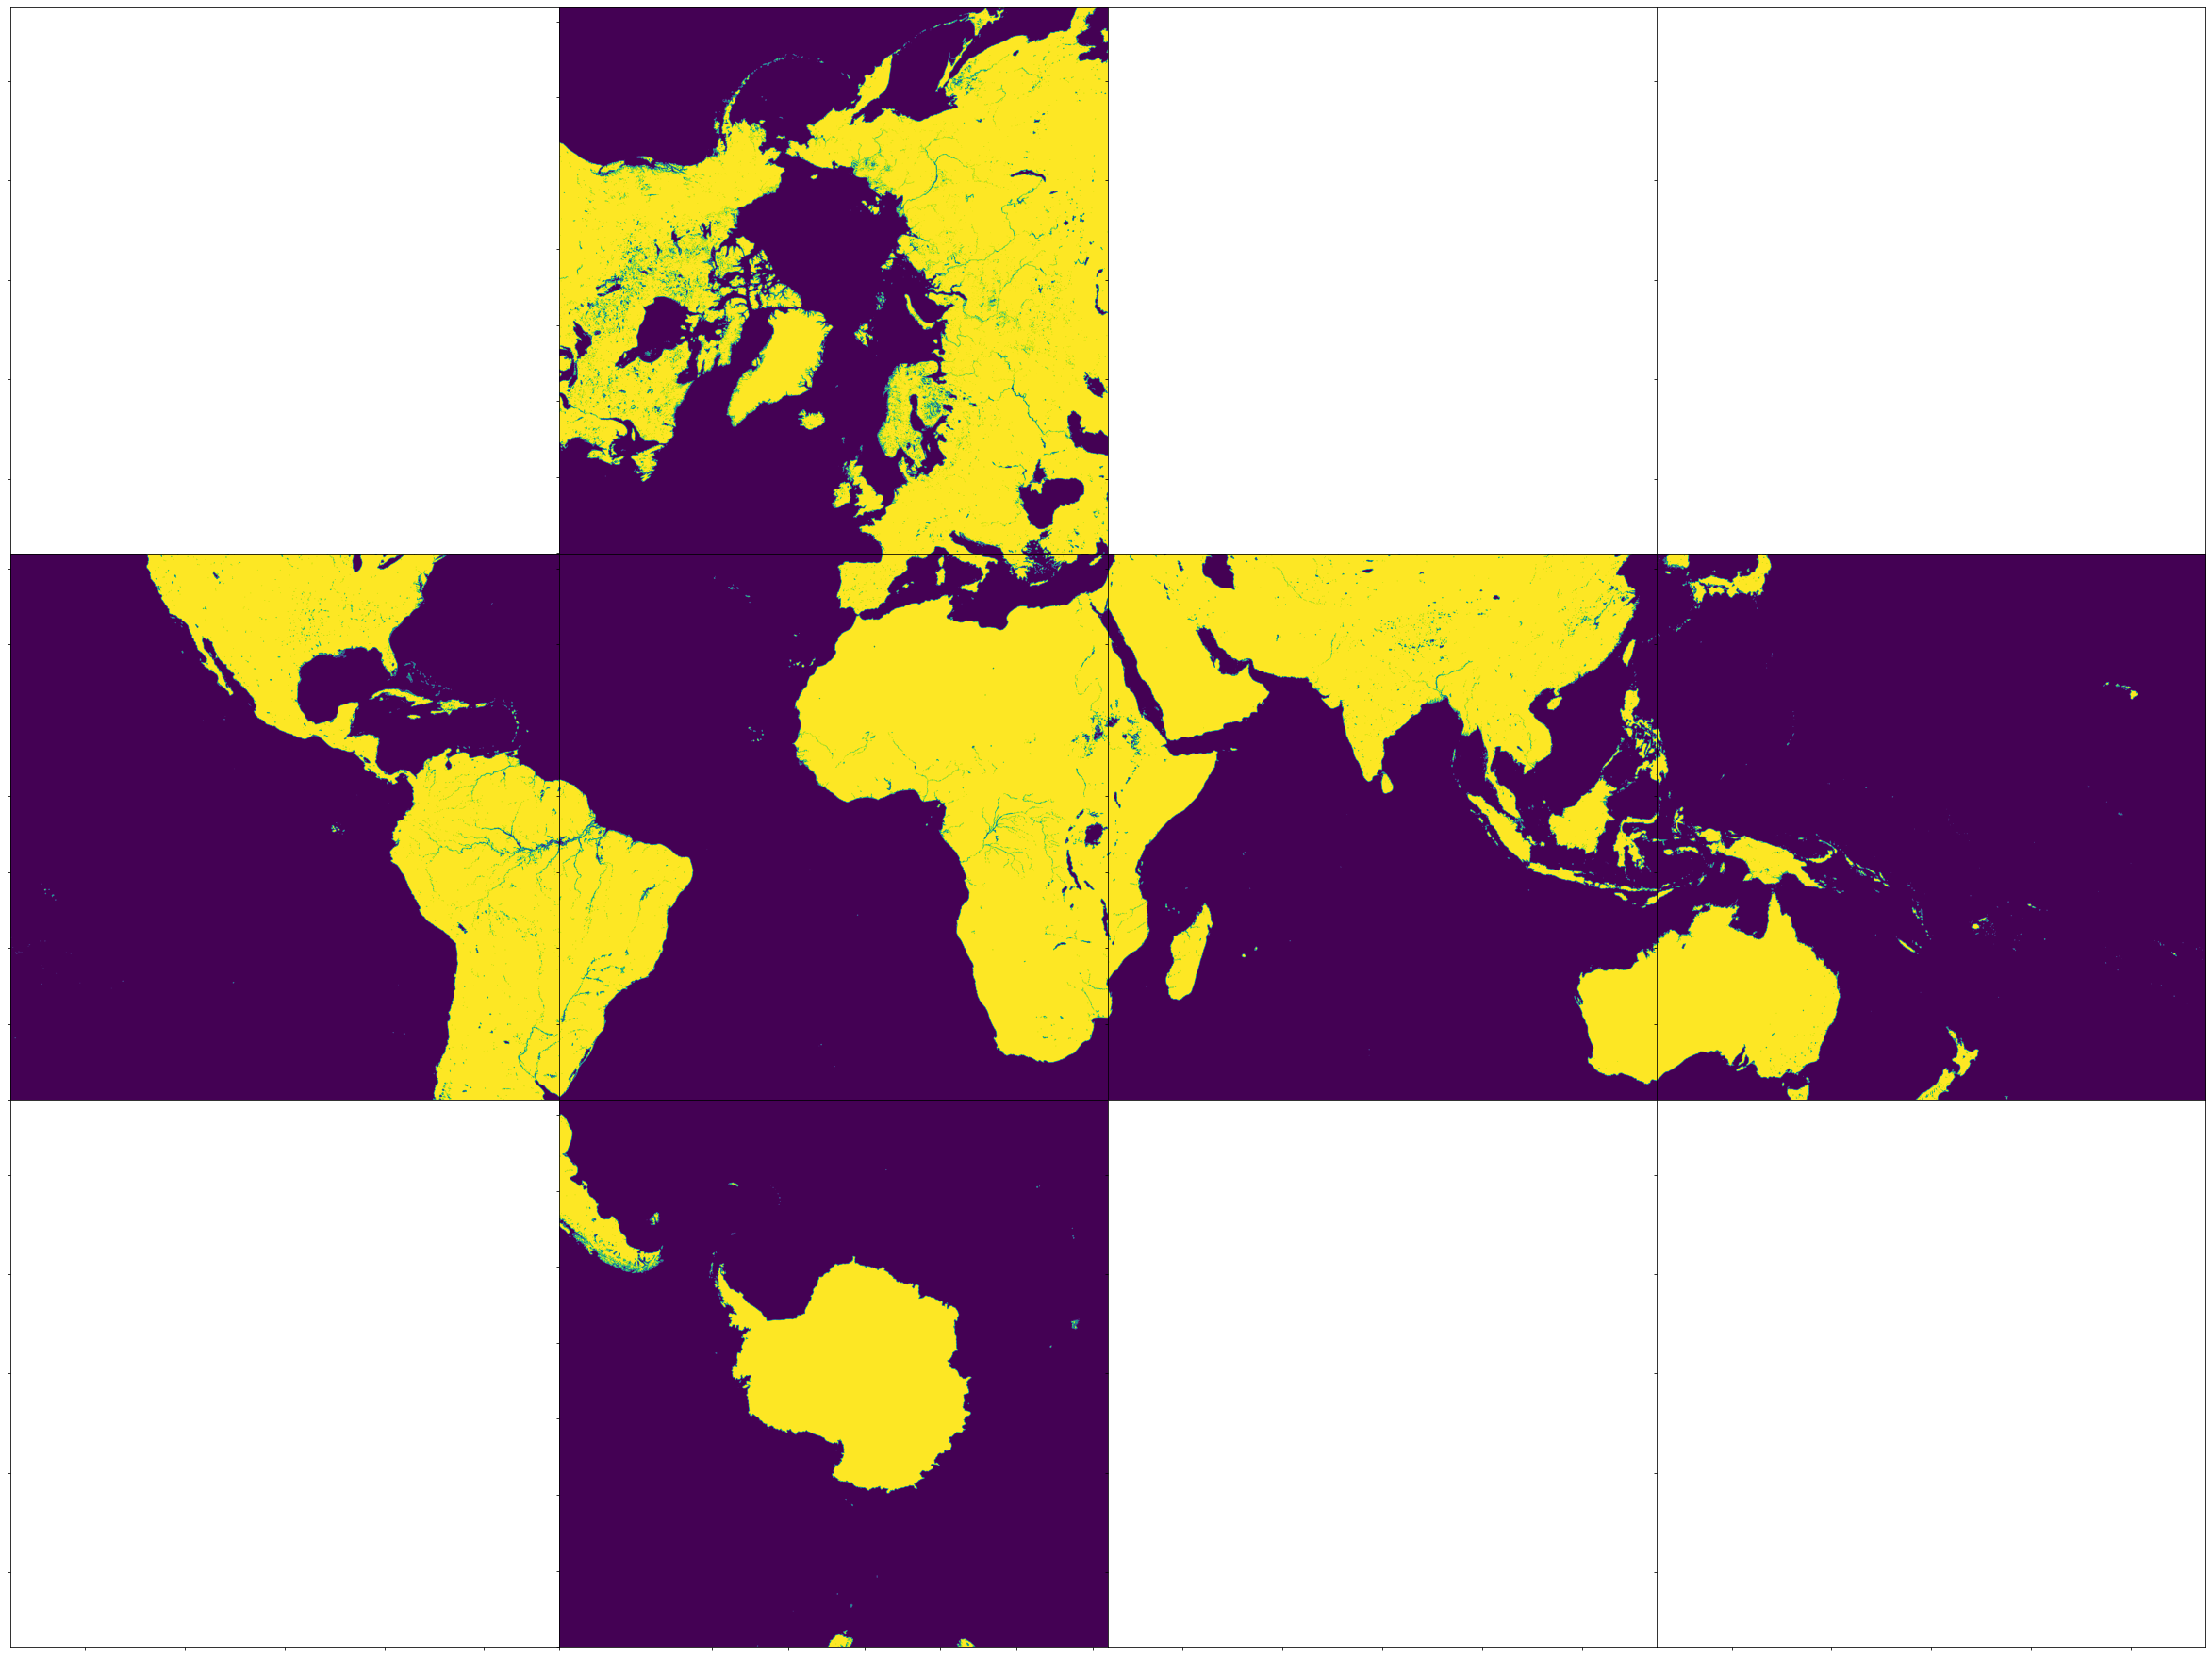

In [18]:
plot_geos5_cs1440_layer(dd["FRLAND"][:,:,:]+dd["FRLANDICE"][:,:,:])

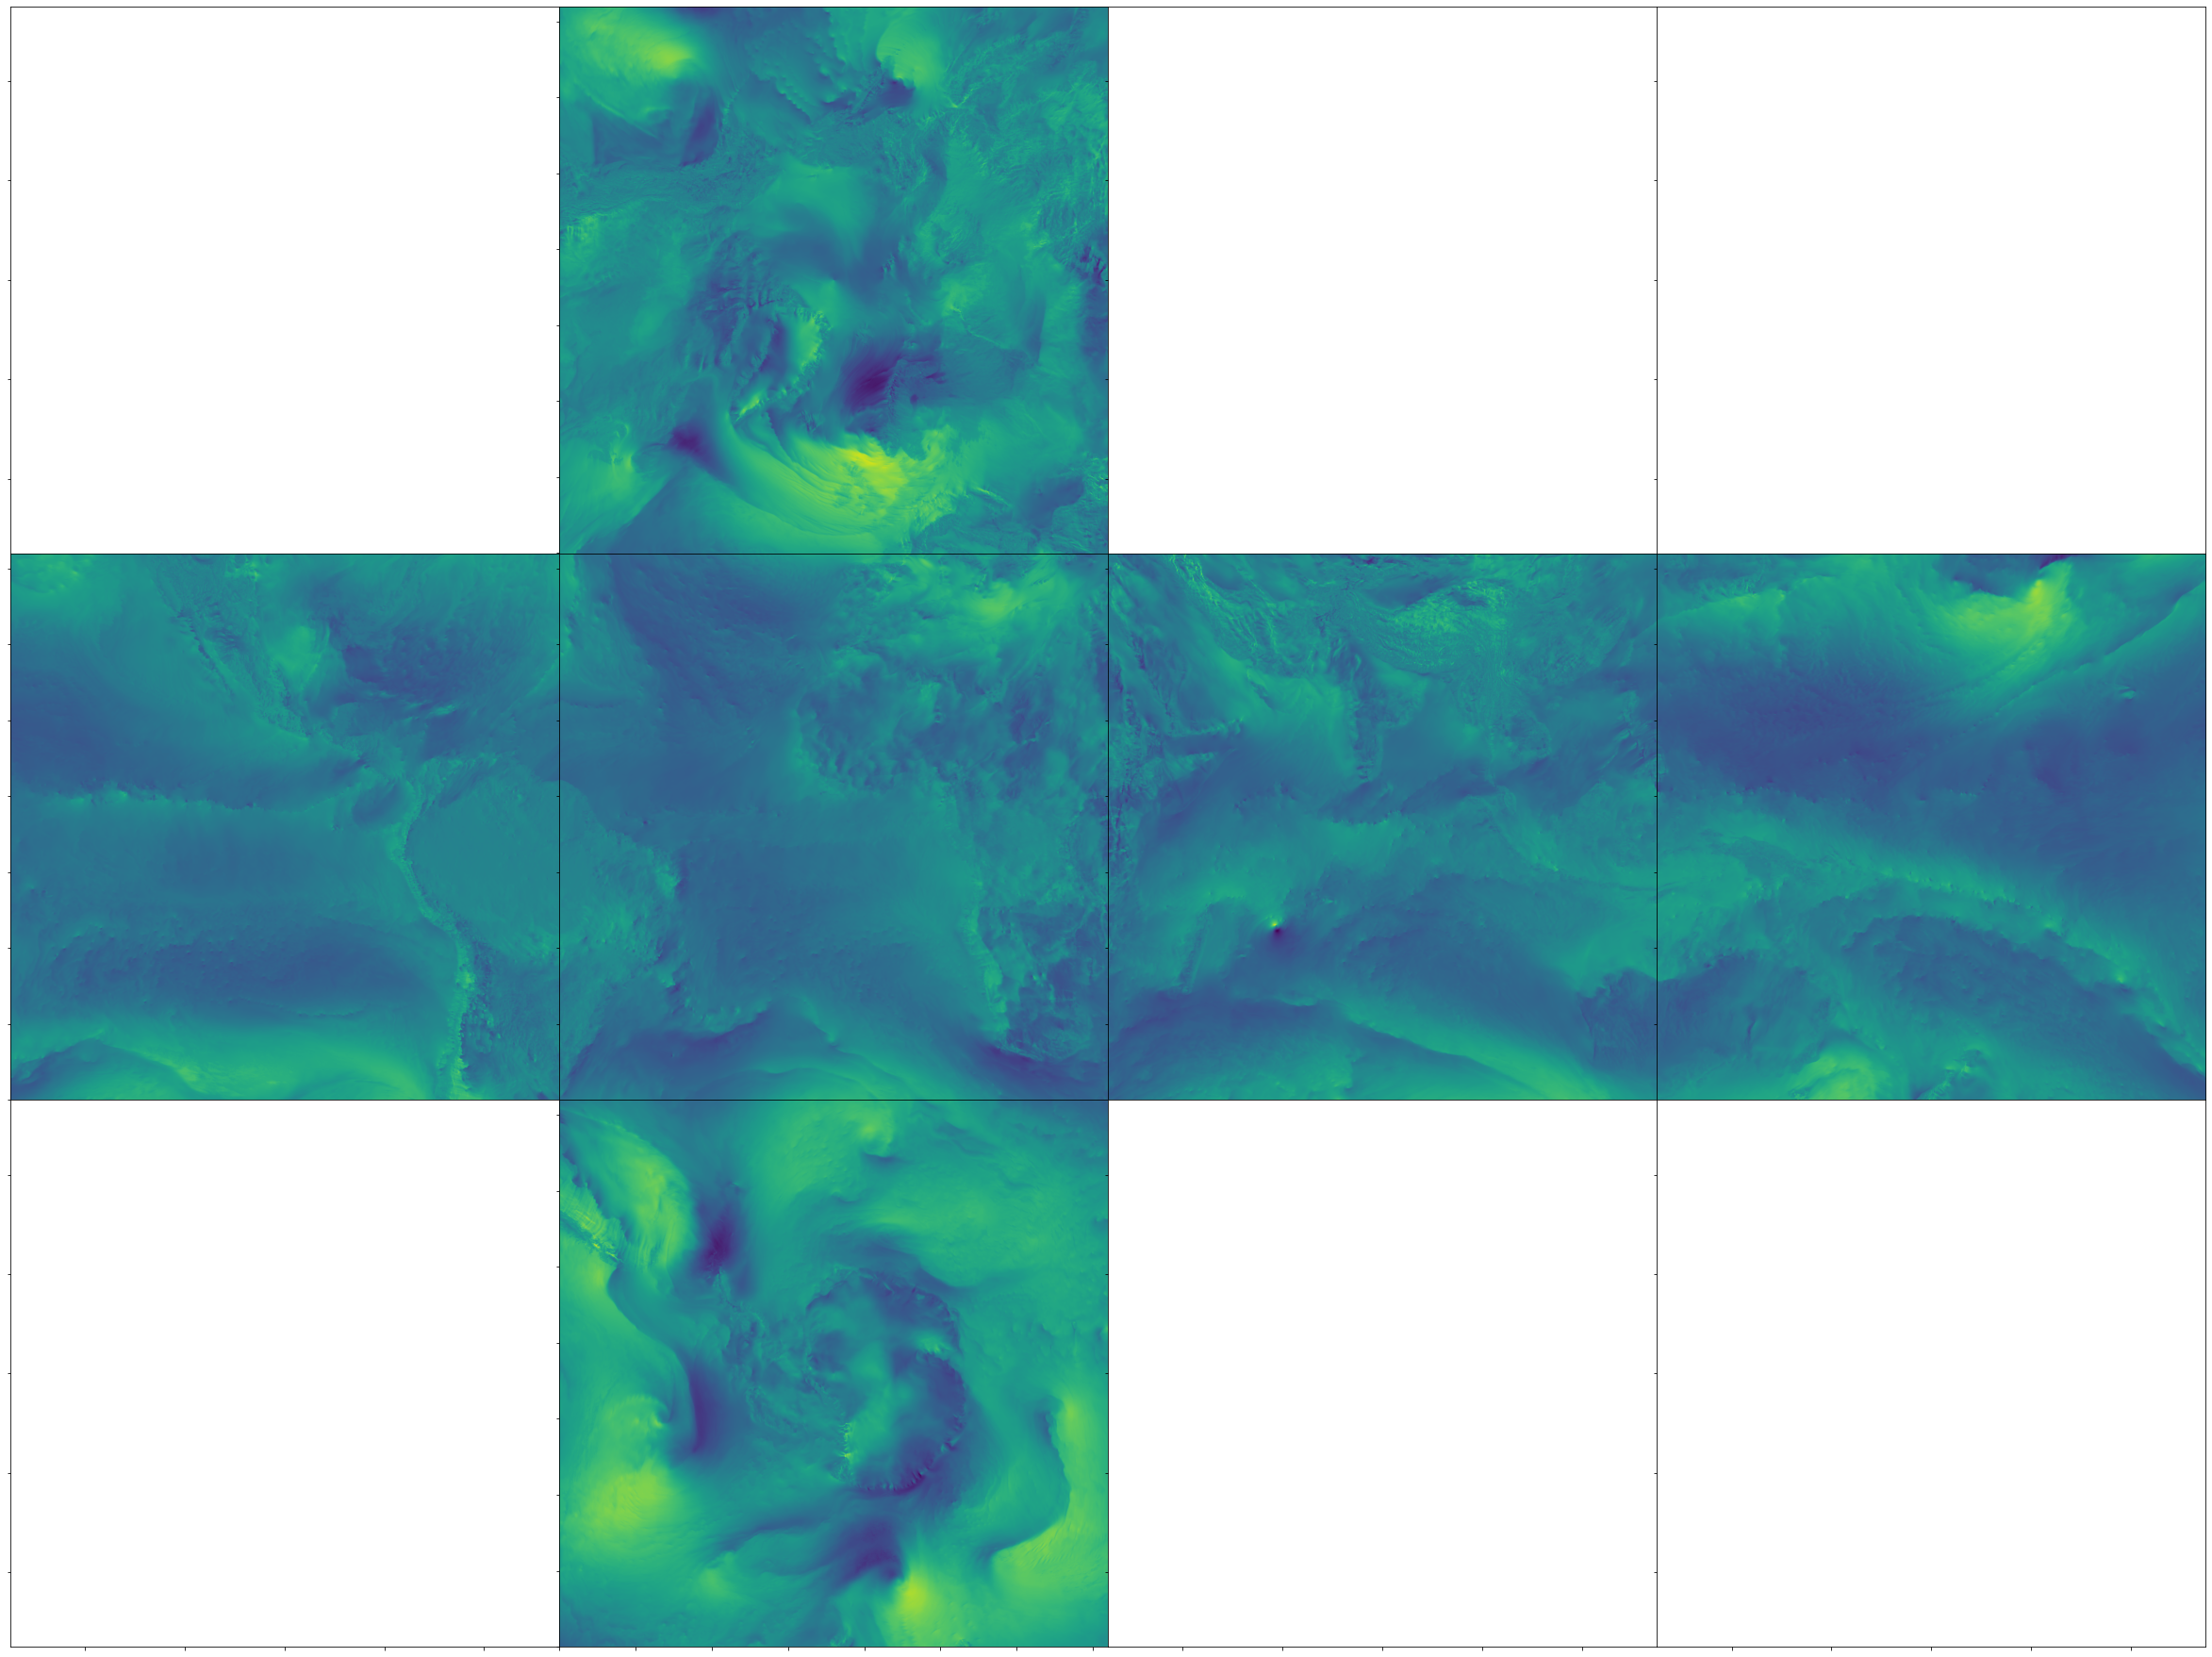

In [19]:
plot_geos5_cs1440_layer(phiU)

(1440, 1440)


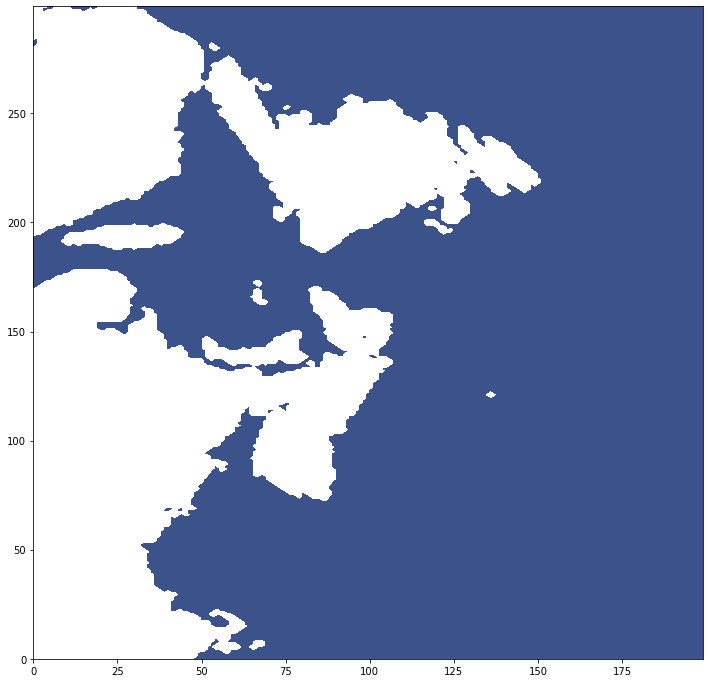

In [20]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12,12))
lm=np.fliplr(np.flipud(phi[0,2880:2880+1440,:]))
print( lm.shape )
lm[lm!=0]=float("NaN")
plt.contourf(lm[0:300,1100:1300]);

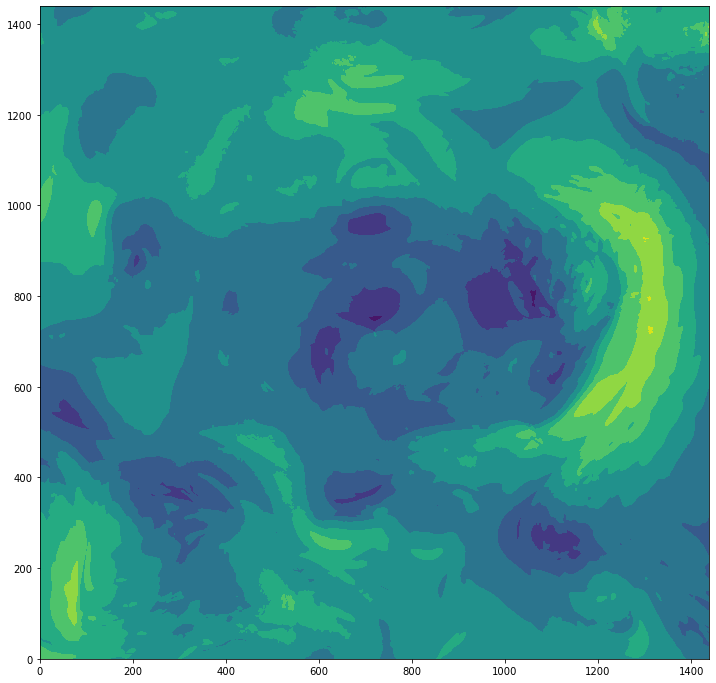

In [21]:
phiU=ds["U"][:,30,:,:] 
fig = plt.figure(figsize=(12,12))
ul=np.fliplr(np.flipud(phiU[0,2880:2880+1440,:]))
plt.contourf(ul[:,:]);

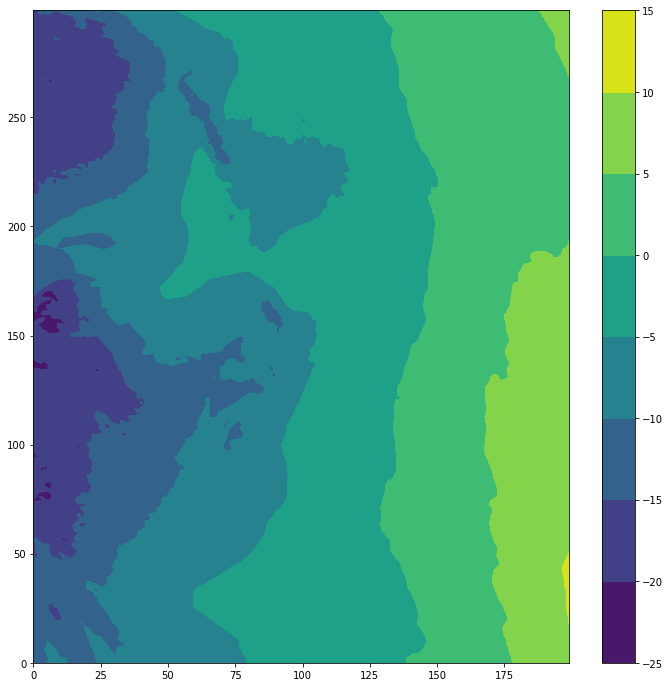

In [22]:
phiT=dt["T"][:,51,:,:] 
fig = plt.figure(figsize=(12,12))
ul=np.fliplr(np.flipud(phiT[0,2880:2880+1440,:]))
plt.contourf(ul[0:300,1100:1300]-273);plt.colorbar();

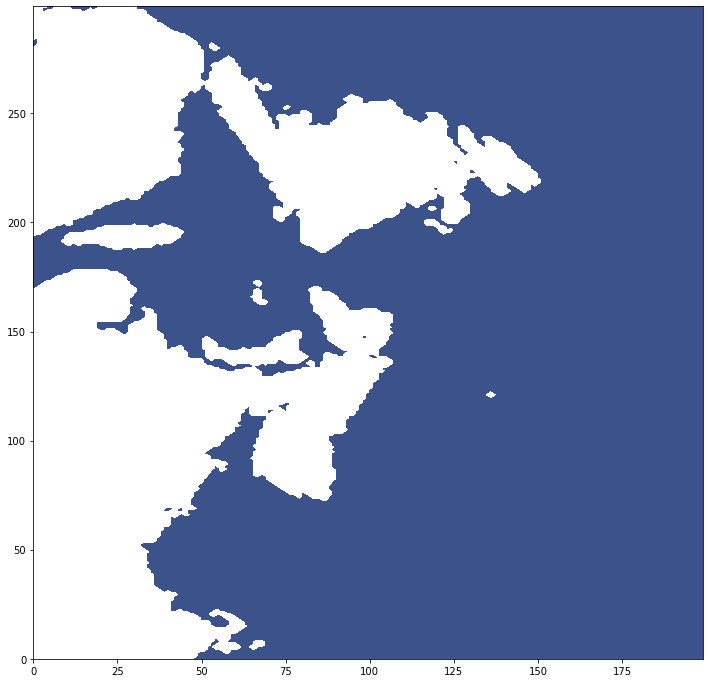

In [23]:
ig = plt.figure(figsize=(12,12))
lm=np.fliplr(np.flipud(phi[0,2880:2880+1440,:]))
lm[lm!=0]=float("NaN")
plt.contourf(lm[0:300,1100:1300]);

In [24]:
elap=time.time()-t0
print(elap)

26.400733947753906
